<a href="https://colab.research.google.com/github/natalia0911/Tarea_Practica_2_IA/blob/main/2022_1_Trabajo_Practico_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Primer Semestre 2022**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Práctico:** 02

**Datos de la entrega:** Lunes 02 de mayo 2022, a más tardar a las 11:59 pm

**Estudiantes:**
- Natalia Vanessa Vargas Reyes
- Estudiante_2





___

# Parte 1  -  Ejercicio  (80 puntos)
___

## Introducción

Considere:
- Se le proporciona un conjunto de datos (HousePriceDataset), si desea conocer un poco de los atributos puede consultar en: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.  Usaremos como punto de partida para este TP-2, solo los que incluye el archivo adjunto.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación.  Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: SalePrice.
- Debe comentar ampliamente su código


In [1]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

### 1 (10 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atritubos.


In [3]:
dataset = pd.read_csv('HousePriceDataset.csv', header = 0, delimiter=';')  
#print(dataset.describe())
print(dataset.head(5))

   Id  MSSubClass MSZoning Neighborhood  OverallQual RoofStyle BsmtQual  \
0   1          60       RL      CollgCr            7     Gable       Gd   
1   2          20       RL      Veenker            6     Gable       Gd   
2   3          60       RL      CollgCr            7     Gable       Gd   
3   4          70       RL      Crawfor            7     Gable       TA   
4   5          60       RL      NoRidge            8     Gable       Gd   

  HeatingQC CentralAir  1stFlrSF  GrLivArea  BsmtFullBath KitchenQual  \
0        Ex          Y       856       1710             1          Gd   
1        Ex          Y      1262       1262             0          TA   
2        Ex          Y       920       1786             1          Gd   
3        Gd          Y       961       1717             1          Gd   
4        Ex          Y      1145       2198             1          Gd   

  GarageType GarageFinish  GarageCars PavedDrive  SalePrice  
0     Attchd          RFn           2          Y

####Matriz de correlación
Con esta podemos ver de manera sencilla la relación entre los valores de los distintos atributos, aunque para este caso solo los numéricos.
Un valor de correlación alto y positivo indica que los elementos miden la misma destreza o característica.

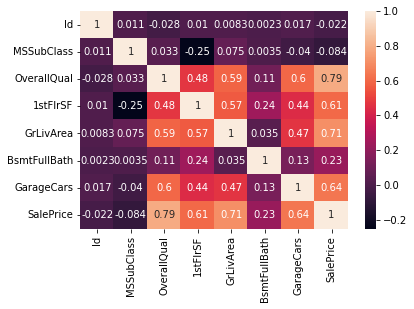

In [9]:
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=True)

####Histogramas
A continuación se muestran histogramas de los atributos. Esto nos permitirá ver las distribuciones de los mismos, y determinar cuales son ordinales o categoricos, de manera que más adelante se puedan tomar las medidas del caso codificando esos determinados atributos.

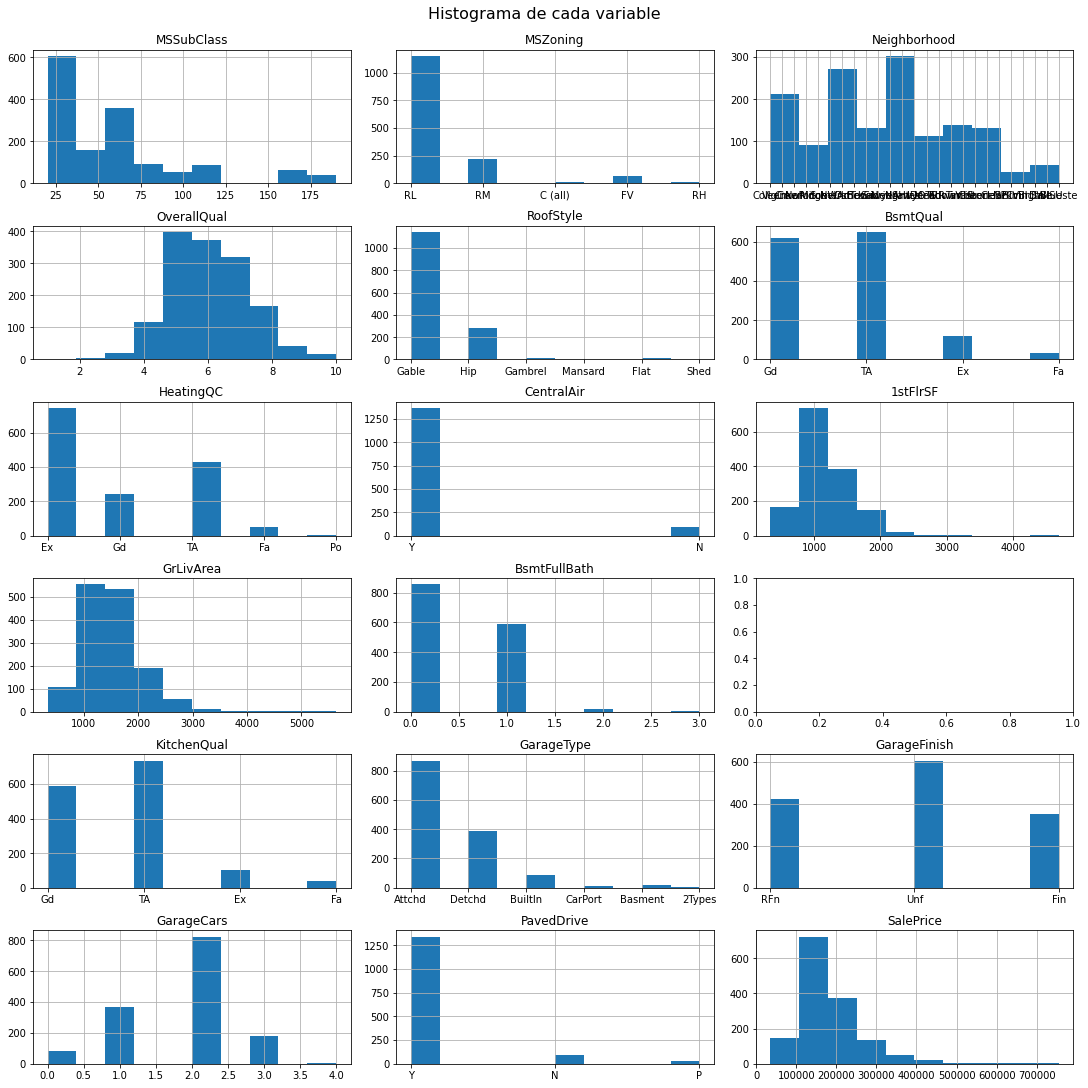

In [5]:
# Se grafica con un histograma cada uno de los atributos
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(15,15))
fig.suptitle('Histograma de cada variable', fontsize=16)

d = 1
for i in range(6):
  for j in range(3):
    if i == 3 and j == 2:
      break
    else:
      axs[i,j].set_title(dataset.columns[d])
      dataset.iloc[:, d].hist(ax=axs[i,j])
      d += 1
plt.show()

Como se puede observar con las gráficas, tenemos varios atributos que se podrían codificar ya que son variables que deberían ser binarias, tal es el caso de MSZoning, Neighborhood, RoofStyle, CentralAir, BsmFullBath, GarageType, GarageFinish, y PavedDrive.

Por otro lado, las variables BsmtQual, HeatingQC y KitchenQual, parecen ser ordinales, pues se manejan con valores Ex, Gd, TA, Fa, Po, de Excellent, Good, Typical average, Fair, y Poor, es decir que y tienen un orden especifico, pues unos valores pesan más que otros. 

####Diagrama de cajas y bigotes

In [6]:
#Primero comprobemos los tipos de cada columna 
print(dataset.dtypes)

Id               int64
MSSubClass       int64
MSZoning        object
Neighborhood    object
OverallQual      int64
RoofStyle       object
BsmtQual        object
HeatingQC       object
CentralAir      object
1stFlrSF         int64
GrLivArea        int64
BsmtFullBath     int64
KitchenQual     object
GarageType      object
GarageFinish    object
GarageCars       int64
PavedDrive      object
SalePrice        int64
dtype: object


Se imprimieron los tipos de los datos para verificar cuáles se podían graficar en un diagrama de bigotes, el cuál nos ayudará a detectar outliers. Este tipo de diagramas es útil en este caso ya que nos permité ver los valores que se alejan de la media y sobresalen de los mínimos y máximos.

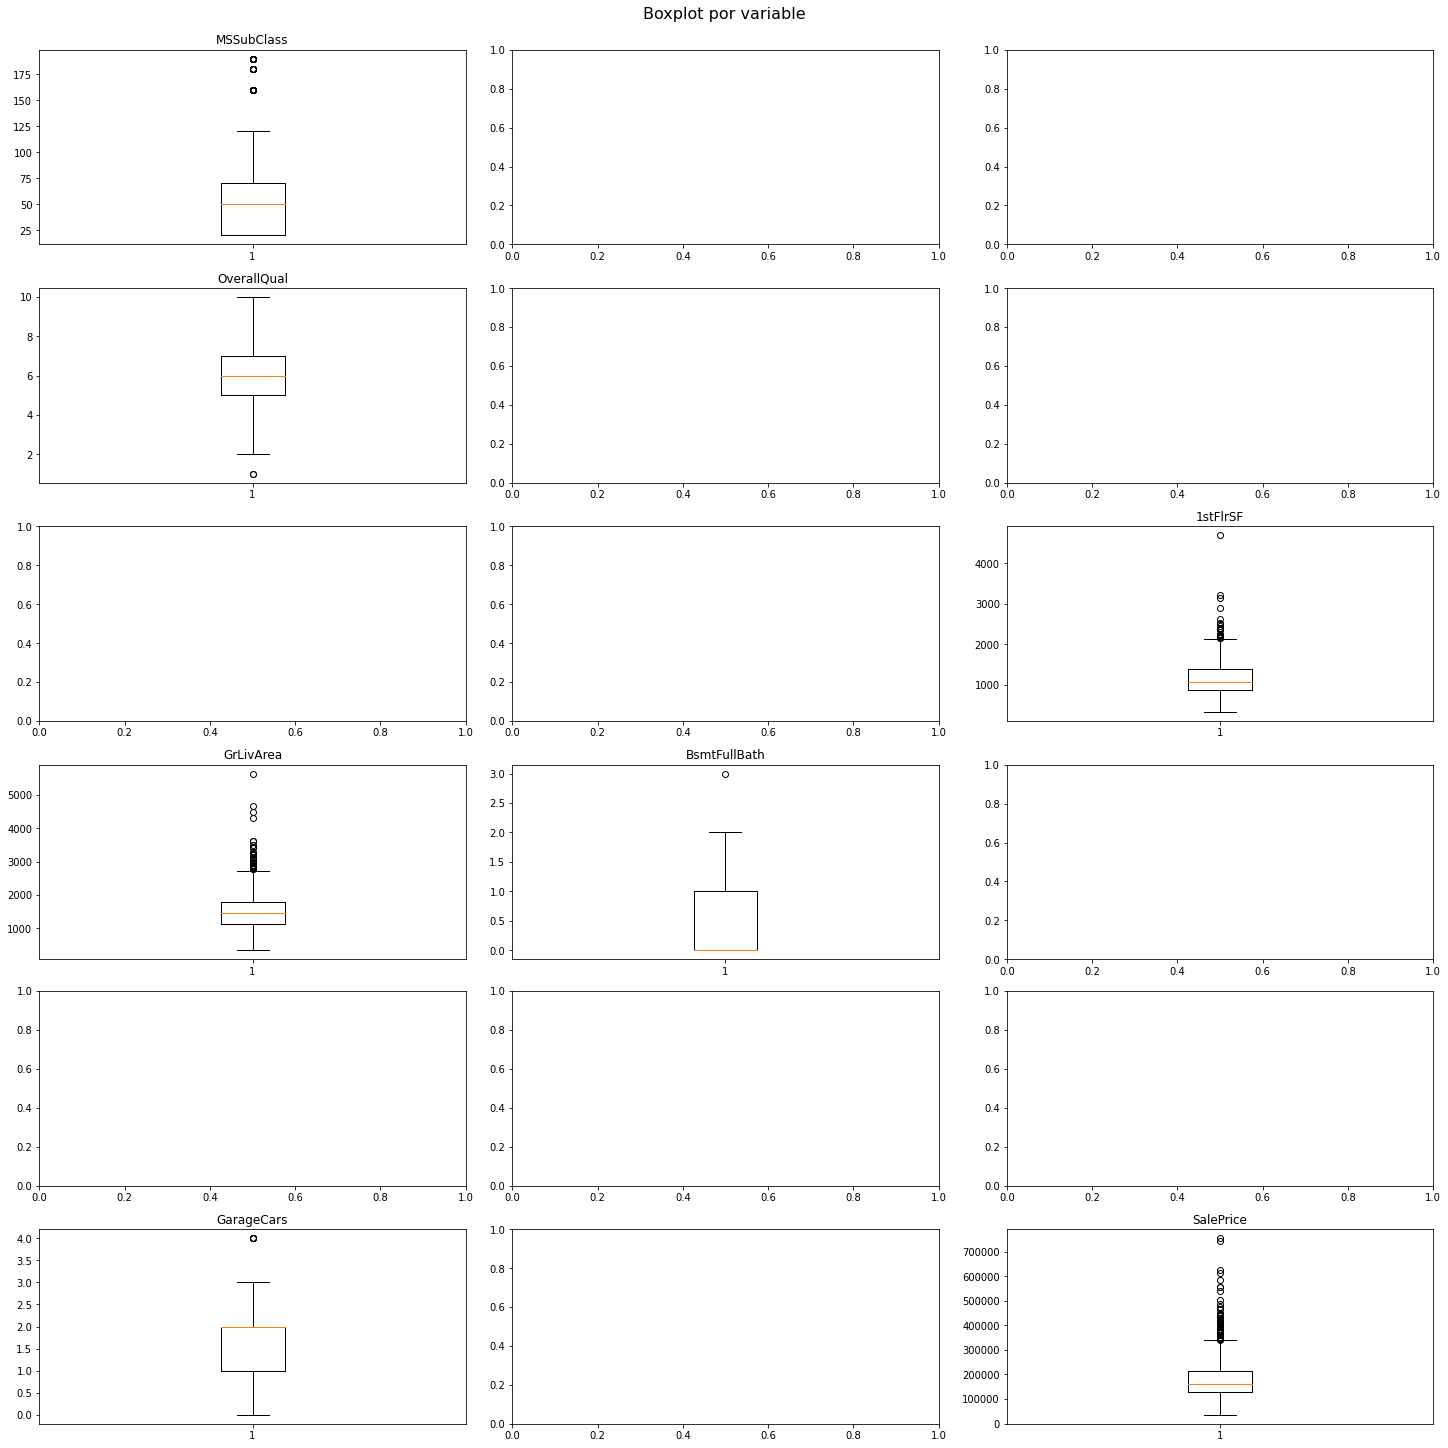

In [7]:

# Se grafica con un boxplot cada uno de los atributos enteros
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(20,20))
fig.suptitle('Boxplot por variable', fontsize=16)

d = 1
for i in range(6):
  for j in range(3):
    if i == 3 and j == 2:
      break
    else:
      if dataset[dataset.columns[d]].dtypes == "int64":
        axs[i,j].set_title(dataset.columns[d])
        axs[i,j].boxplot(dataset.iloc[:,d])
      d += 1


Podemos notar que las variables presentan valores atípicos, con esto podemos pensar que hace falta hacer un tratamiento de esos. De momento esto nos sirve para observar de manera gráfica que hay valores que se alejan mucho de la media. Más adelante podemos revisar las filas que tienen outliers y hacer algún preprocesamiento de los mismos si fuera el caso, ya a veces tener outliers que no son tan irrelistas o que presentan algún tipo de patrón que se presenta cada cierto tiempo y en casos como ese tampoco es ideal quitarlos.

####Valores faltantes
Aparte de observar los datos y notar que hay valores faltantes, podemos imprimir cuantos valores hay para cada atributo, y como sabemos que tenemos 1460 filas o muestras, notar que uno de los atributos de menos de eso, indicaría que hay valores que más adelante tendremos que tratar, ya sea rellenarlos, ignorarlos o usar algún algoritmo más complejo. 

In [8]:
print("Cantidad de muestras ",len(dataset), "\n")
print(dataset.count())


Cantidad de muestras  1460 

Id              1460
MSSubClass      1460
MSZoning        1460
Neighborhood    1460
OverallQual     1460
RoofStyle       1460
BsmtQual        1423
HeatingQC       1460
CentralAir      1460
1stFlrSF        1460
GrLivArea       1460
BsmtFullBath    1460
KitchenQual     1460
GarageType      1379
GarageFinish    1379
GarageCars      1460
PavedDrive      1460
SalePrice       1460
dtype: int64


### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%)  y Test (30%). 
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe  los  conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.


Primero se separan las columnas

In [10]:
my_data = dataset
X = my_data.iloc[:, :17]
cantidad_muestras = len(my_data)
y = my_data.iloc[:, 17]


print("\nMuestra fila 1: ",X[0:1])
print("\nCantidad de muestras: ", len(my_data))
#print(my_data.info())
print("\nCantidad de atributos (incluye y): ", my_data.shape[1])




Muestra fila 1:     Id  MSSubClass MSZoning Neighborhood  OverallQual RoofStyle BsmtQual  \
0   1          60       RL      CollgCr            7     Gable       Gd   

  HeatingQC CentralAir  1stFlrSF  GrLivArea  BsmtFullBath KitchenQual  \
0        Ex          Y       856       1710             1          Gd   

  GarageType GarageFinish  GarageCars PavedDrive  
0     Attchd          RFn           2          Y  

Cantidad de muestras:  1460

Cantidad de atributos (incluye y):  18


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.70,
                                                    shuffle=True,     #Mezclar los datos y que se reparta aleatoriamente
                                                    random_state=40)  #Definir una semilla para usar los mismos valores en todas las corridas

print("\nTamaño de X_train + X_test: ", len(X_train)+len(X_test))
print("\nTamaño del train: ", len(X_train))
print("\nTamaño del test: ", len(X_test))
print("\nPrimeros elementos del X_train:")
print( X_train[0:4])
print("\nPrimeros elementos del X_test:")
print( X_test[0:4])
print("\nPrimeros elementos del y_train:")
print( y_train[0:4])
print("\nPrimeros elementos del y_test:")
print( y_test[0:4])


Tamaño de X_train + X_test:  1460

Tamaño del train:  1021

Tamaño del test:  439

Primeros elementos del X_train:
        Id  MSSubClass MSZoning Neighborhood  OverallQual RoofStyle BsmtQual  \
8        9          50       RM      OldTown            7     Gable       TA   
309    310          20       RL      NridgHt            9     Gable       Ex   
957    958          20       RL       Sawyer            5       Hip       TA   
1022  1023          50       RM      OldTown            5     Gable       TA   

     HeatingQC CentralAir  1stFlrSF  GrLivArea  BsmtFullBath KitchenQual  \
8           Gd          Y      1022       1774             0          TA   
309         Ex          Y      1944       1944             1          Ex   
957         TA          Y      1057       1057             0          TA   
1022        Gd          Y       912       1248             0          TA   

     GarageType GarageFinish  GarageCars PavedDrive  
8        Detchd          Unf           2        

####Comentario sobre shuffle y random_state
Shuffle es un atributo que se debe poner en True si se quieren mezclar los datos, esto nos ayudará con la aletoriedad y en este caso se decidió hacer de esta forma porque es eso precesimente lo que andamos buscando al separar el train del test.

Por otro lado el random_state, se debe poner en algún valor, un valor inicial que se define por medio de una semilla y es importante ponerlo si queremos que en todas las corridas se usen los mismos valores random, esto es muy útil cuando se trabaja con muestras y no poner un valor en el atributo haría que cada vez que se ejecute el programa, se use uno distinto y por lo tanto cada vez use valores diferentes. 



### 3  (15 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

####Remover outliers EDITAR ESTO
Anteriormente observamos las variables númericas por medio de diagramas de cajas, las cuales nos permitieron mostrar que ciertas variables presentan valores atípicos, estas eran MSSubClass, OverallQual, 1stFlrSF, GrLivArea, GarageCars y SalePrice. Vamos a observar los valores y a 
eliminarlos o NO SÉ ALGO. HAY QYE VER QUE HACER CON ESTOS, QUIZÁ NO SEA NECESARIO QUITARLOS

---------------- Resumen Estadístico de la variable ----------------
        MSSubClass
count  1460.000000
mean     56.897260
std      42.300571
min      20.000000
25%      20.000000
50%      50.000000
75%      70.000000
max     190.000000
-----------------Ver outliers -----------------
1       20
6       20
10      20
12      20
13      20
        ..
1453    20
1454    20
1456    20
1458    20
1459    20
Name: MSSubClass, Length: 536, dtype: int64
9       190
48      190
93      190
125     190
165     190
246     190
291     190
300     190
312     190
335     190
411     190
488     190
520     190
535     190
635     190
637     190
703     190
705     190
713     190
861     190
969     190
985     190
1030    190
1062    190
1144    190
1186    190
1190    190
1266    190
1393    190
1416    190
Name: MSSubClass, dtype: int64
---------------- Resumen Estadístico de la variable después de quitar outliers----------------
count    1460.000000
mean       56.897260
std        42.30057

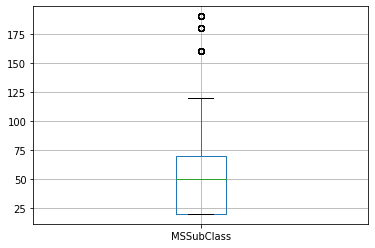

In [34]:
data = pd.DataFrame(dataset.MSSubClass)
data.boxplot()

print("---------------- Resumen Estadístico de la variable ----------------")
print(data.describe())

values = dataset.MSSubClass
print("-----------------Ver outliers -----------------")
print(values[values.between(values.quantile(0), values.quantile(.003))] )
print(values[values.between(values.quantile(.997), values.quantile(1))] )

#Remover Outliers
dataset = dataset.loc[values.between(values.quantile(0.001), values.quantile(.998)), :]
print("---------------- Resumen Estadístico de la variable después de quitar outliers----------------")
print(dataset.MSSubClass.describe())

####Valores faltantes
Como vimos en la primera parte, hay algunas variables que tienen valores faltantes, debemos hacer algo con esos campos y tenemos varias opciones como ignorar dichas tuplas, rellenar con constantes, usar media o moda, el valor más probable o quizá usar un algoritmo más complejo como una imputación multivariada. 
En este caso, las variables con valores faltantes son BsmtQual, que es una variable ordinal, GarageType, que es una variable binaria y GarageFinish que también es binaria.
Quizá lo mejor en este caso es usar la moda, es decir el dato que más se repite, esto se debe simplemente al tipo de datos que son, ya que la media y mediana quizá no tengan mucho sentido en este contexto.

In [13]:
print(X_train.count())
print('--------------------')
print(X_test.count())

Id              1021
MSSubClass      1021
MSZoning        1021
Neighborhood    1021
OverallQual     1021
RoofStyle       1021
BsmtQual         994
HeatingQC       1021
CentralAir      1021
1stFlrSF        1021
GrLivArea       1021
BsmtFullBath    1021
KitchenQual     1021
GarageType       960
GarageFinish     960
GarageCars      1021
PavedDrive      1021
dtype: int64
--------------------
Id              439
MSSubClass      439
MSZoning        439
Neighborhood    439
OverallQual     439
RoofStyle       439
BsmtQual        429
HeatingQC       439
CentralAir      439
1stFlrSF        439
GrLivArea       439
BsmtFullBath    439
KitchenQual     439
GarageType      419
GarageFinish    419
GarageCars      439
PavedDrive      439
dtype: int64


In [14]:
X_train.BsmtQual = X_train.BsmtQual.fillna(X_train['BsmtQual'].mode()[0])
X_train.GarageType = X_train.GarageType.fillna(X_train['GarageType'].mode()[0])
X_train.GarageFinish = X_train.GarageFinish.fillna(X_train['GarageFinish'].mode()[0])

X_test.BsmtQual = X_test.BsmtQual.fillna(X_test['BsmtQual'].mode()[0])
X_test.GarageType = X_test.GarageType.fillna(X_test['GarageType'].mode()[0])
X_test.GarageFinish = X_test.GarageFinish.fillna(X_test['GarageFinish'].mode()[0])


print(X_train.count())
print('--------------------')
print(X_test.count())


Id              1021
MSSubClass      1021
MSZoning        1021
Neighborhood    1021
OverallQual     1021
RoofStyle       1021
BsmtQual        1021
HeatingQC       1021
CentralAir      1021
1stFlrSF        1021
GrLivArea       1021
BsmtFullBath    1021
KitchenQual     1021
GarageType      1021
GarageFinish    1021
GarageCars      1021
PavedDrive      1021
dtype: int64
--------------------
Id              439
MSSubClass      439
MSZoning        439
Neighborhood    439
OverallQual     439
RoofStyle       439
BsmtQual        439
HeatingQC       439
CentralAir      439
1stFlrSF        439
GrLivArea       439
BsmtFullBath    439
KitchenQual     439
GarageType      439
GarageFinish    439
GarageCars      439
PavedDrive      439
dtype: int64


####Codificar atributos ordinales
Como habíamos visto con el hisgrama, las variables BsmtQual, HeatingQC, y KitchenQual, son variables ordinales, ya que poseen unicamente 6 valores distintos y además tienen un orden específico que es Excellent, Good, Typical average, Fair, y Poor. Entonces lo que vamos a hacer es asignarle un valor numerico a cada valor ordinal para poder tratarlos adecuadamente. 

In [15]:

mapping = { "Ex" :5,"Gd" :4,"TA":3, "Fa" :2, "Po":1 }    
X_test = X_test.replace(mapping)
X_train = X_train.replace(mapping)
print(X_train.head(5))
print("------------------------------------------------------")
print(X_test.head(5))


        Id  MSSubClass MSZoning Neighborhood  OverallQual RoofStyle  BsmtQual  \
8        9          50       RM      OldTown            7     Gable         3   
309    310          20       RL      NridgHt            9     Gable         5   
957    958          20       RL       Sawyer            5       Hip         3   
1022  1023          50       RM      OldTown            5     Gable         3   
78      79          90       RL       Sawyer            4       Hip         3   

      HeatingQC CentralAir  1stFlrSF  GrLivArea  BsmtFullBath  KitchenQual  \
8             4          Y      1022       1774             0            3   
309           5          Y      1944       1944             1            5   
957           3          Y      1057       1057             0            3   
1022          4          Y       912       1248             0            3   
78            3          N      1768       1768             0            3   

     GarageType GarageFinish  GarageCars Pav

####Codificar atributos binarios
Como lo descubrimos en la primer parte, por medio de gráficas, específicamente histogramas, existen algunas variables categoricas que deberían codificarse a binario, en este caso porque no indican ninguna forma de orden significativa, como los atributos del punto anterior, y por lo tanto de esta forma indicamos que ninguno tiene más peso que otro o mayor probabilidad que el resto, de modo que las columnas se codifican en binario, marcando con un 1 la casilla del atributo correspondiente y el resto en 0. 
Las variables a codificar son MSZoning, Neighborhood, RoofStyle, CentralAir, BsmFullBath, GarageType, GarageFinish, y PavedDrive.

In [16]:
pd.options.display.max_columns = None

X_test = pd.get_dummies(X_test, columns=["MSZoning"])
X_train = pd.get_dummies(X_train, columns=["MSZoning"])

X_test = pd.get_dummies(X_test, columns=["Neighborhood"])
X_train = pd.get_dummies(X_train, columns=["Neighborhood"])

X_test = pd.get_dummies(X_test, columns=["RoofStyle"])
X_train = pd.get_dummies(X_train, columns=["RoofStyle"])

X_test = pd.get_dummies(X_test, columns=["CentralAir"])
X_train = pd.get_dummies(X_train, columns=["CentralAir"])

X_test = pd.get_dummies(X_test, columns=["BsmtFullBath"])
X_train = pd.get_dummies(X_train, columns=["BsmtFullBath"])

X_test = pd.get_dummies(X_test, columns=["GarageType"])
X_train = pd.get_dummies(X_train, columns=["GarageType"])

X_test = pd.get_dummies(X_test, columns=["GarageFinish"])
X_train = pd.get_dummies(X_train, columns=["GarageFinish"])

X_test = pd.get_dummies(X_test, columns=["PavedDrive"])
X_train = pd.get_dummies(X_train, columns=["PavedDrive"])

print(X_train.head(1))

   Id  MSSubClass  OverallQual  BsmtQual  HeatingQC  1stFlrSF  GrLivArea  \
8   9          50            7         3          4      1022       1774   

   KitchenQual  GarageCars  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  \
8            3           2                 0            0            0   

   MSZoning_RL  MSZoning_RM  Neighborhood_Blmngtn  Neighborhood_BrDale  \
8            0            1                     0                    0   

   Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  \
8                     0                     0                     0   

   Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
8                     0                     0                     0   

   Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  \
8                    0                     0                     0   

   Neighborhood_NAmes  Neighborhood_NPkVill  Neighborhood_NWAmes  \
8                   0                     0           

In [17]:
#COMPROBAR LA NUEVA CANTIDAD DE ATRIBUTOS
print("\nCantidad de atributos train (no incluye y): ", X_train.shape[1])
print("\nCantidad de atributos test (no incluye y): ", X_test.shape[1])


Cantidad de atributos train (no incluye y):  62

Cantidad de atributos test (no incluye y):  62


### 4 (10 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- ¿Qué hará con el atributo denominado: "Id"?
- Comente sus conclusiones.


####Lasso

In [18]:
#CONSULTA: CUANDO SE HACE LASSO PARA REDUCIR ATRIBUTOS... SE HACE CON TODO EL CONJUNTO?
# O SE HACE CON EL TRAIN, Y LEUGO SE ELIMINAN LAS COLUMNAS DEL TRAIN Y TEST QUE SON CERCANAS A 0 O MENORES?
print("Método de selección de atributos lasso")
reg = linear_model.Lasso(alpha=1.0, fit_intercept=False)    #PREGUNTAR QUE HACER CON EL NORMALIZAR, Y CON EL BIAS 
reg.fit(X_train, y_train)                                                 #PREGUNTAR SI SE HACE CON EL TRAIN Y EL TEST 
#Solo se hace con el train, y se lo quito tanto al test como al train
print( "Coeficientes: ", reg.coef_ )

Método de selección de atributos lasso
Coeficientes:  [-4.62712062e+00 -1.78698950e+02  1.16047507e+04  1.11827599e+04
  1.80734419e+03  1.64998494e+00  4.96669363e+01  1.21471324e+04
  1.07158963e+04 -9.87833559e+04 -6.36301972e+04 -5.05718300e+04
 -5.47635033e+04 -6.97910757e+04 -1.19938154e+04  2.69844393e+03
 -8.83481852e+02  1.02797973e+04 -7.71508387e+03  1.12370626e+04
 -2.35173501e+04 -1.57936682e+04  1.06622929e+03 -7.90804194e+02
 -1.14257286e+04 -1.31810000e+04 -3.52529949e+03 -1.13918630e+04
  6.90808384e+04  5.04282830e+04 -1.39471472e+04 -2.18444674e+04
 -1.18652430e+04 -1.45776645e+04  1.16872032e+04  6.79244429e+04
  8.83964539e+02  3.60319543e+04  5.65399907e+03 -4.80406146e+03
  1.89995457e+04  2.65593565e+03 -5.97543224e+03 -1.03847626e+04
 -2.33716039e+03  1.69395028e+02 -6.86533136e+03  5.82630674e+03
  2.60454200e+03  7.13891316e+04 -1.90127076e+04  4.42141619e+03
  6.67333146e+03  6.18953488e+02 -2.13183240e+04 -1.51449587e+02
  5.38280545e+03 -3.18703213e+03 -1.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.357e+11, tolerance: 4.047e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [19]:
columns_names = X_train.columns.values
for i in range(len(reg.coef_)):
  if not reg.coef_[i]>1:
    X_train = X_train.drop([columns_names[i]], axis=1)
    X_test = X_test.drop([columns_names[i]], axis=1)
    np.delete(columns_names, i)
    print("Eliminated ", columns_names[i], reg.coef_[i])


Eliminated  Id -4.62712061784243
Eliminated  MSSubClass -178.69895019541894
Eliminated  MSZoning_C (all) -98783.3559201139
Eliminated  MSZoning_FV -63630.197218229594
Eliminated  MSZoning_RH -50571.830044941955
Eliminated  MSZoning_RL -54763.50325387775
Eliminated  MSZoning_RM -69791.07567460777
Eliminated  Neighborhood_Blmngtn -11993.815418261347
Eliminated  Neighborhood_BrkSide -883.481852370168
Eliminated  Neighborhood_CollgCr -7715.083871994063
Eliminated  Neighborhood_Edwards -23517.350145156986
Eliminated  Neighborhood_Gilbert -15793.668161801188
Eliminated  Neighborhood_MeadowV -790.8041938731373
Eliminated  Neighborhood_Mitchel -11425.728566224547
Eliminated  Neighborhood_NAmes -13180.99995070607
Eliminated  Neighborhood_NPkVill -3525.299491920079
Eliminated  Neighborhood_NWAmes -11391.86299006419
Eliminated  Neighborhood_OldTown -13947.147201112653
Eliminated  Neighborhood_SWISU -21844.46742328348
Eliminated  Neighborhood_Sawyer -11865.242956550397
Eliminated  Neighborhood_Saw

In [20]:
print("\nCantidad de atributos train (no incluye y): ", X_train.shape[1])
new_columns_names = X_train.columns.values
print(len(new_columns_names))


Cantidad de atributos train (no incluye y):  29
29


### 1.5  (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'HousePriceDatasetPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).


####RobustScaler 
Decidimos usar este método para escalar los datos, ya que al usar el rango intercualitico, estarían menos distribuidos nuestros datos. Puede ser un punto a favor, ya que no se eliminaron los outliers, pues no eran excesivamente lejanos ni tampoco incoherentes como para quitarlos. 
En este caso el escalamiento robusto no es sensible a outliers por lo que hará un mejor escalamiento para el caso de nuestro conjunto de datos. 

####Bias
Por otro lado, el bias no se manejará de momento, pues dicha columna puede ser agregada con el parametro fit_intercept en el modelo que se utilice para la predicción, por lo que agregará hasta el siguiente punto de la tarea programa, donde se aplican tres modelos. 

In [22]:
# Escalar datos
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform( X_train)
X_test = transformer.transform( X_test)
print("Primeros X_train: ", X_train[0:1])
print("Primeros X_test: ", X_test[0:1])

Primeros X_train:  [[ 0.5        -1.         -0.5        -0.13017751  0.47462687  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -1.          0.          0.          0.          0.        ]]
Primeros X_test:  [[ 0.5         0.          0.          0.15384615 -0.43283582  1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.          1.          1.          0.
   0.          0.          0.          1.          0.        ]]


In [23]:

#JUNTAR XTRAIN,YTRAIN, XTEST,YTEST :)
new_columns_names = np.append(new_columns_names,'SalePrice')
print(new_columns_names)

X_concat = np.concatenate((X_train,X_test), axis=0)

Y_concat = np.concatenate((y_train,y_test), axis=0)
#Se convierte a matriz y luego se hace columna
Y_concat = np.asmatrix(Y_concat)
Y_concat = np.transpose(Y_concat)
#Se agrega la columna de Y 
data = np.concatenate((X_concat,Y_concat), axis=1)

#Guardar el dataset en un csv
X_df = pd.DataFrame(data = data, columns = new_columns_names)
X_df.to_csv("HousePriceDatasetPROCESADO.csv",index=False)


['OverallQual' 'BsmtQual' 'HeatingQC' '1stFlrSF' 'GrLivArea' 'KitchenQual'
 'GarageCars' 'Neighborhood_BrDale' 'Neighborhood_ClearCr'
 'Neighborhood_Crawfor' 'Neighborhood_IDOTRR' 'Neighborhood_NoRidge'
 'Neighborhood_NridgHt' 'Neighborhood_Somerst' 'Neighborhood_StoneBr'
 'Neighborhood_Timber' 'Neighborhood_Veenker' 'RoofStyle_Flat'
 'RoofStyle_Gambrel' 'RoofStyle_Hip' 'CentralAir_Y' 'BsmtFullBath_1'
 'BsmtFullBath_2' 'BsmtFullBath_3' 'GarageType_Attchd'
 'GarageType_Basment' 'GarageType_BuiltIn' 'GarageFinish_Fin'
 'PavedDrive_P' 'SalePrice']


### 1.6 (20 puntos)
Presente e implemente un diseño experimental que incluya:
- Tres algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted eligirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para los otros dos métodos, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para selecionar la mejor configuración (Justifique su selección).
    
**Nota:** Para cada el algoritmo adicional seleccionado (no el OLSR) explique los parámetros que recibe. 
    

In [24]:
def muestreMetricas(py_test, py_pred, psquared):
    metrica = mean_squared_error(py_test, py_pred, squared=psquared)
    # If True returns MSE value, if False returns RMSE value.
    if psquared:
        print("RMSE: ", metrica)
    else: 
        print("MSE: ", metrica)
    print("R2: ", r2_score(py_test, py_pred) )

####Regresion lineal de mínimos cuadrados sin regularización OLSR
Para este modelo se agrega la columna del bias, como se mencionó en el punto anterior pues al momento de modelar sí no es importante. Además cabe mencionar que se puso el parametro mormalize porque para este modelo está obsoleta, y por defecto no normaliza y no lo necesitamos porque anteriormente se usó el escalamiento robusto. 

In [25]:
print( "Regresion lineal de mínimos cuadrados sin regularización OLSR")

regression = linear_model.LinearRegression( 
                                           fit_intercept=True,
                                           copy_X=True, 
                                           n_jobs=None)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
muestreMetricas(y_test, y_pred, True)



Regresion lineal de mínimos cuadrados sin regularización OLSR
RMSE:  1467516394.99095
R2:  0.7178142042159666


In [26]:
def getBestAlpha(resultados):
    mejor = math.inf
    elMejor = 0.0
    for e in resultados:
        if resultados[e] < mejor:
            mejor = resultados[e]
            elMejor = e
    return mejor, elMejor

####Regresión Ridge con Ten-Cross-Validation

Como realmente no se especificó hacer más que un nuevo algoritmo, para el segundo se eleigió Ridge, en este caso el normalize está en desuso y el default es no hacerlo, pero ya hemos escalado los datos. 

In [32]:

print("\nTamaño del train-validation: ", len(X_train))
print("\nTamaño del test: ", len(X_test))

print("\nCantidad de muestras: ", len(X_train)+len(X_test))

#Hiperparametros 
alfas = [10**i for i in (-4,-3,-2,-1,0,1,2,3,4) ]
resultados_alfa = {}
numFolds = 10 #Para el ten cross validatiom 
print('-----------------------------------------------------------------------')

for alfa in alfas:
    kf = KFold(n_splits=numFolds,
               shuffle=True,
               random_state=10)
    resultados = []
    kf.get_n_splits(X_train)


    keysY = y_train.keys()

    for train_index, val_index in kf.split(X_train): 
      
        X_train_tmp = X_train[train_index]
        X_val_tpm = X_train[val_index]
        y_train_tmp = y_train[keysY[train_index]]
        y_val_tmp = y_train[keysY[val_index]]

        clf = linear_model.Ridge(alpha=alfa, fit_intercept=True)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val_tpm)
        metrica = mean_squared_error(y_val_tmp, y_pred, squared=False)
        # If True returns MSE value, if False returns RMSE value.
        resultados.append(metrica)

    promedio = sum(resultados) / len(resultados) 
    print("\nMétricas obtenidas en cross-validation para alfa de: ", alfa, " - ", resultados, 
          "     con un promedio de: ", promedio)
    resultados_alfa[alfa] = promedio

print('-----------------------------------------------------------------------')
print("\nResultados del Train-Validation: ", resultados_alfa)
mejor_metrica, mejor_alfa = getBestAlpha(resultados_alfa)
print('-----------------------------------------------------------------------')
print("\nMejor valor de métrica en Train-Validation: ", mejor_metrica,", Alfa: ", mejor_alfa,)

#Entrenar y predecir con el mejor alfa
clf = linear_model.Ridge(alpha=mejor_alfa, fit_intercept=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#Mostrar R2 y RMSE
muestreMetricas(y_test, y_pred, True)



Tamaño del train-validation:  1021

Tamaño del test:  439

Cantidad de muestras:  1460
-----------------------------------------------------------------------

Métricas obtenidas en cross-validation para alfa de:  0.0001  -  [27067.733831897192, 40614.416975148044, 37644.94753193743, 28065.495334971056, 36569.35334334165, 24541.72141156058, 27093.68828589155, 44480.726240548014, 26006.76551697166, 39095.69131458145]      con un promedio de:  33118.05397868486

Métricas obtenidas en cross-validation para alfa de:  0.001  -  [27067.5919765797, 40614.54446977408, 37644.90438218477, 28065.251764053748, 36569.35934262586, 24541.75534104138, 27093.318552418965, 44481.10138439382, 26006.67297511262, 39095.73920328353]      con un promedio de:  33118.02393914685

Métricas obtenidas en cross-validation para alfa de:  0.01  -  [27066.173080380155, 40615.82349529686, 37644.47611500381, 28062.820872896413, 36569.42294561039, 24542.09831343369, 27089.624690705303, 44484.884442848655, 26005.7505487

#### Lasso LARS con Ten-Cross-Validation
El tercer algororitmo se realizó con un modelo diferente a los vistos en clase, en este caso el Lasso LARS, El algoritmo Least angle regression (LAR) está fuertemente conectado con el Lasso, y de
hecho proporciona un procedimiento muy eficiente para computar el Lasso. 
Es similar a la regresión hacia adelante, en donde el primer paso es identificar la variable más correlacionada, es decir, dado un conjunto de vectores se selecciona el vector que tenga la correlación absoluta más grande con la respuesta. En vez de adaptarse a esta variable, incrementa continuamente el valor del vector estimado hasta el punto donde la dirección del vector tenga la misma correlación con el residuo actual, este nuevo coeficiente entra al conjunto activo y el proceso continúa. 

En este caso el parámetro que recibe es alpha que es la constante que multiplica el término de penalización.

In [33]:

print("\nTamaño del train-validation: ", len(X_train))
print("\nTamaño del test: ", len(X_test))

print("\nCantidad de muestras: ", len(X_train)+len(X_test))

#Hiperparametros 
alfas = [10**i for i in (-4,-3,-2,-1,0,1,2,3,4) ]
resultados_alfa = {}
numFolds = 10 #Para el ten cross validatiom 
print('-----------------------------------------------------------------------')

for alfa in alfas:
    kf = KFold(n_splits=numFolds,
               shuffle=True,
               random_state=10)
    resultados = []
    kf.get_n_splits(X_train)


    keysY = y_train.keys()

    for train_index, val_index in kf.split(X_train): 
      
        X_train_tmp = X_train[train_index]
        X_val_tpm = X_train[val_index]
        y_train_tmp = y_train[keysY[train_index]]
        y_val_tmp = y_train[keysY[val_index]]

        clf = linear_model.LassoLars(alpha=alfa, fit_intercept=True, normalize=False)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val_tpm)
        metrica = mean_squared_error(y_val_tmp, y_pred, squared=False)
        # If True returns MSE value, if False returns RMSE value.
        resultados.append(metrica)

    promedio = sum(resultados) / len(resultados) 
    print("\nMétricas obtenidas en cross-validation para alfa de: ", alfa, " - ", resultados, 
          "     con un promedio de: ", promedio)
    resultados_alfa[alfa] = promedio

print('-----------------------------------------------------------------------')
print("\nResultados del Train-Validation: ", resultados_alfa)
mejor_metrica, mejor_alfa = getBestAlpha(resultados_alfa)
print('-----------------------------------------------------------------------')
print("\nMejor valor de métrica en Train-Validation: ", mejor_metrica,", Alfa: ", mejor_alfa,)

#Entrenar y predecir con el mejor alfa
clf = linear_model.LassoLars(alpha=alfa, fit_intercept=True, normalize=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#Mostrar R2 y RMSE
muestreMetricas(y_test, y_pred, True)


Tamaño del train-validation:  1021

Tamaño del test:  439

Cantidad de muestras:  1460
-----------------------------------------------------------------------

Métricas obtenidas en cross-validation para alfa de:  0.0001  -  [27067.749798974906, 40614.40296830519, 37644.951994146206, 28065.522114069812, 36569.35265692093, 24541.71806243006, 27093.728462267456, 44480.68480801095, 26006.775792824803, 39095.68638048833]      con un promedio de:  33118.05730384387

Métricas obtenidas en cross-validation para alfa de:  0.001  -  [27067.7516511756, 40614.40435974713, 37644.94897152827, 28065.51950621201, 36569.352441791496, 24541.721812263444, 27093.720281220758, 44480.686732506416, 26006.77570358098, 39095.689809567455]      con un promedio de:  33118.057126959364

Métricas obtenidas en cross-validation para alfa de:  0.01  -  [27067.77017480234, 40614.4182759623, 37644.91874692725, 28065.493429109865, 36569.350292052135, 24541.759312484995, 27093.638472581188, 44480.70598892665, 26006.774



### 1.7 (15 puntos)

- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.  
- Qué conclusiones finales saca sobre los métodos usados como predictores.

___

# Parte 2  -  Temas por grupo (20 puntos)
___

Considere lo siguiente:
1. Revise en el archivo PDF: "Temas por grupo", qué cuadernos jupyter le corresponden a su grupo.
1. Estudie los cuadernos asignados.
1. Prepare un único cuaderno de jupyter (comentando con celdas de texto en español), en que resume y explica las técnicas asignadas.  Debe buscar uno o más datasets diferentes a los que se usan en los cuadernos de jupyter asignados. Deberá adjuntar a su solución el cuaderno jupyter generado y el o los datasets que Usted propone usar en sus cuadernos.
1. Prepare un video para una posible presentación de sus temas en clase, no debe durar más 15 minutos en la presentación de los temas asignados (Considere que el material preparado será compartido con sus compañer(a/o)s del curso y por tanto se espera que se esmere en su elaboración y clara explicación -- por favor -- ).